# Full-waveform inversion using Forge

In this notebook we apply full-waveform inversion (FWI) to a small, simple demo model. FWI is a high-resolution data-intensive tomographic imaging method, originally developed in geophysics for imaging the subsurface. 

By default, Forge will automatically attempt to run the forward modelling and inversion on the GPU. If a suitably configured cuda-enabled GPU is not available, it will revert to the CPU. The problem presented here is intentially small enough so that this is not an issue. 

### Contents

1. Model definition
2. Acquisition setup
3. Forward modelling
4. Optimization

## 1. Model definition

In [1]:
# Choose the frequency (in Hz) of the source wavelet and the acoustic velocities of the model
frequency = 2e5
min_vel = 1480
med_vel = 1520
max_vel = 1620

Set the spatial increment, `dx`, to be small enough to sufficiently mitigate numerical dispersion by ensuring there are a 6 grid-points per wavelength.

In [2]:
min_wavelength = min_vel/frequency
dx = min_wavelength/6
print(f'spatial increment dx: {dx:.3g}')

spatial increment dx: 0.00123


Set the temporal increment, `dt`, to be small enough to meet the CFL condition for numerical stability. 

In [3]:
courant_num = 0.6
dt = (courant_num*dx)/max_vel
print(f'temporal increment dt: {dt:.3g}')

temporal increment dt: 4.57e-07


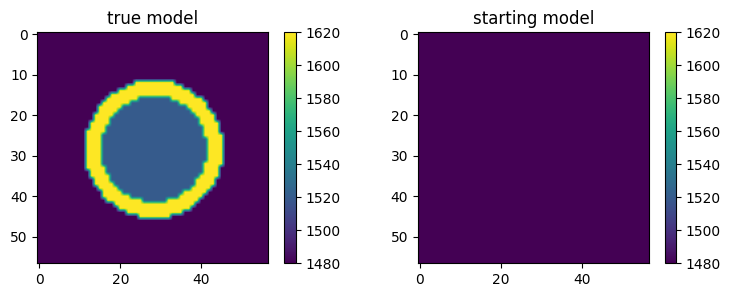

In [4]:
from utils import demo_model

# Define the true model, m, and the inversion starting model m0
m, m0 = demo_model(dx, min_vel, med_vel, max_vel, plot=True)

## 2. Acquisition setup

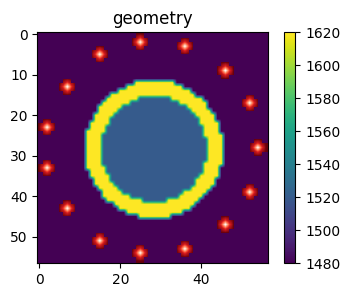

In [5]:
from utils import demo_geometry

# Define the receiver and source geometry in terms of their grid cell positions
r_pos = demo_geometry(m, n_elements=15, plot=True)
s_pos = r_pos.copy()

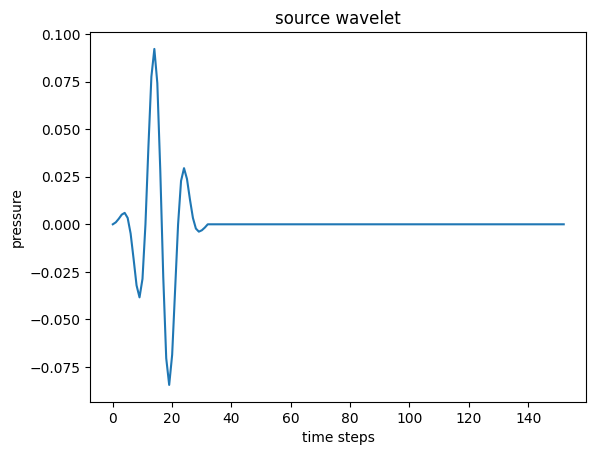

In [6]:
from forge.utils import tone_burst

time = 0.00007  # Maximum time in seconds
amplitude = 1e-1  #  Maximum source pressure 
num = round(time/dt) #  Number of time-steps
num_cycles = 3  # Use a 3 cycle tone-burst

# Define the source wavelet 
source = tone_burst(dt, frequency, num_cycles, num, amplitude, plot=True)

## 3. Forward modelling

Generate synthetic "target" acoustic data using the acquisition setup and true model that have been defined. In a real-world scenario, this will be data obtained from an ultrasound acquisition system.

In [7]:
from forge.model import FullWaveformInversion

# Instantiate a FullWaveformInversion class to run the forward modelling
true_model = FullWaveformInversion(model = m,  # True model
                                   dx = dx,  # Spatial increment
                                   dt = dt,  # Temporal increment
                                   r_pos = r_pos)  # Receiver positions

device = cuda:0


In [8]:
# Forward modelling using the source wavelet at the source positions
true_model.forward(s_pos, source)

forward modelling:   0%|                                | 0/153 [00:00<?, ?it/s]

forward modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 344.76it/s]


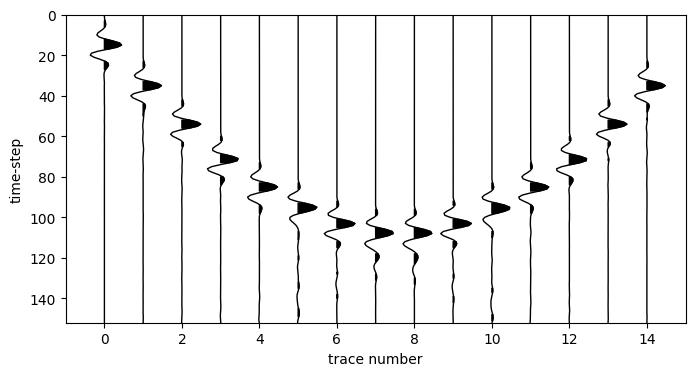

In [9]:
from forge.utils import trace_plot, normalize

# Visualize traces of true modelled data
trace_plot(normalize(true_model.d), 0)

In [10]:
from pyslice import slicer, render

shot=0
wavefield = true_model.wavefield.cpu()[shot]
scale = wavefield.abs().max()/3

# Animate second partial derivative of the wavefield w.r.t time, scaled by the acoustic velocity model
ani = slicer(wavefield,
             animate=True,
             vmin=-scale,
             vmax=scale,
             cmap='seismic',
             title='Second wavefield derivative')
render(ani)

## 4. Inversion

In [11]:
# Instantiate a new FullWaveformInversion class for the inversion
model = FullWaveformInversion(model = m0,  # Starting model
                              dx = dx,  # Spatial increment
                              dt = dt,  # Temporal increment
                              r_pos = r_pos)  # Receiver positions

device = cuda:0


### Optimizers

PyTorch contains a suite of optimizers that can be selected and tuned accordingly.

In [12]:
import torch

# Define a stochastic gradient descent optimizer with momentum
opt = torch.optim.SGD([model.m], lr=1e-5, momentum=0.4)

### Loss function

We can select a PyTorch loss function that suites our purpose. Or we may wish to build our own custom loss function using PyTorch functions.

In [13]:
l2_loss = torch.nn.MSELoss()

# Uncomment to test a custom trace-normalized L2 loss function
#def l2_loss(input, target):
#    return torch.norm(normalize(input) - normalize(target))**2

### Callbacks

A default optimization loop can be executed with `.fit()`. For ease and flexible customization, an arbitrary number of callback functions can be defined to act on:
1. the adjoint source prior to back-propagation and/or
2. the model gradient and/or parameters prior to taking an optimization step.

For example, these could be regularization terms, filters, or plotting functions to visualize adjoint sources or gradients.

In [14]:
from scipy.ndimage import gaussian_filter
from forge.filters import butter_filter

# Define a Gaussian smoothing callback function for the model gradient
def grad_smoothing(m, sigma=0.1):
    m.grad[model.bp:-model.bp, model.bp:-model.bp] = torch.from_numpy(
                gaussian_filter(m.grad.cpu()[model.bp:-model.bp, model.bp:-model.bp], sigma))

# Define a function to low pass filter the adjoint source
def low_pass(adjoint_source):
    adjoint_source = torch.from_numpy(butter_filter(adjoint_source, 4e5, 1/dt, order=12)).float()

In [15]:
# Invert the data with .fit()
model.fit(data = true_model.d,  # True data
          s_pos = s_pos,  # Source locations in grid-cells
          source = source,  # Source wavelet
          optimizer = opt,  # Optimizer
          loss = l2_loss,  # Loss function
          num_iter = 10,  # Number of iterations per frequency block
          bs = 10,  # Batch size/number of sources per forward run
          blocks = [1e5, 2e5],  # Multi-scale frequency blocks
          model_callbacks = [grad_smoothing],  # Apply model/gradient callbacks before the optimization step
          adjoint_callbacks = [low_pass],  # Apply adjoint source callbacks before back-propagation
          box = (min_vel, max_vel),  # Box constraints
          true_model = m)  # True model for reporting inversion RMSE

2024-04-27 20:57:27  block 1/2    1e+05Hz
2024-04-27 20:57:27    iteration 1/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 401.63it/s]


2024-04-27 20:57:28      loss = 7.69e-15
2024-04-27 20:57:28      rmse = 0.01332
2024-04-27 20:57:28    iteration 2/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 401.02it/s]


2024-04-27 20:57:29      loss = 3.674e-15
2024-04-27 20:57:29      rmse = 0.01083
2024-04-27 20:57:29    iteration 3/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 400.77it/s]


2024-04-27 20:57:30      loss = 1.486e-15
2024-04-27 20:57:30      rmse = 0.008999
2024-04-27 20:57:30    iteration 4/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 408.80it/s]


2024-04-27 20:57:30      loss = 6.263e-16
2024-04-27 20:57:30      rmse = 0.007861
2024-04-27 20:57:30    iteration 5/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 401.69it/s]


2024-04-27 20:57:31      loss = 2.608e-16
2024-04-27 20:57:31      rmse = 0.006496
2024-04-27 20:57:31    iteration 6/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 387.64it/s]


2024-04-27 20:57:32      loss = 1.236e-16
2024-04-27 20:57:32      rmse = 0.005571
2024-04-27 20:57:32    iteration 7/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 383.61it/s]


2024-04-27 20:57:33      loss = 9.159e-17
2024-04-27 20:57:33      rmse = 0.005247
2024-04-27 20:57:33    iteration 8/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 402.14it/s]


2024-04-27 20:57:34      loss = 5.045e-17
2024-04-27 20:57:34      rmse = 0.004902
2024-04-27 20:57:34    iteration 9/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 386.90it/s]


2024-04-27 20:57:35      loss = 2.418e-17
2024-04-27 20:57:35      rmse = 0.004667
2024-04-27 20:57:35    iteration 10/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 396.98it/s]


2024-04-27 20:57:35      loss = 2.816e-17
2024-04-27 20:57:35      rmse = 0.004501
_______________________________________________________ 

2024-04-27 20:57:35  block 2/2    2e+05Hz
2024-04-27 20:57:35    iteration 1/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 405.19it/s]


2024-04-27 20:57:36      loss = 6.351e-15
2024-04-27 20:57:36      rmse = 0.004368
2024-04-27 20:57:36    iteration 2/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 402.63it/s]


2024-04-27 20:57:37      loss = 3.966e-15
2024-04-27 20:57:37      rmse = 0.004201
2024-04-27 20:57:37    iteration 3/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 395.22it/s]


2024-04-27 20:57:38      loss = 2.208e-15
2024-04-27 20:57:38      rmse = 0.004021
2024-04-27 20:57:38    iteration 4/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 399.37it/s]


2024-04-27 20:57:39      loss = 5.207e-15
2024-04-27 20:57:39      rmse = 0.003914
2024-04-27 20:57:39    iteration 5/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 375.62it/s]


2024-04-27 20:57:39      loss = 1.306e-15
2024-04-27 20:57:39      rmse = 0.003789
2024-04-27 20:57:39    iteration 6/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 406.28it/s]


2024-04-27 20:57:40      loss = 2.391e-15
2024-04-27 20:57:40      rmse = 0.003788
2024-04-27 20:57:40    iteration 7/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 395.33it/s]


2024-04-27 20:57:41      loss = 3.65e-15
2024-04-27 20:57:41      rmse = 0.003886
2024-04-27 20:57:41    iteration 8/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 410.91it/s]


2024-04-27 20:57:42      loss = 2.263e-14
2024-04-27 20:57:42      rmse = 0.003684
2024-04-27 20:57:42    iteration 9/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 394.33it/s]


2024-04-27 20:57:43      loss = 5.495e-15
2024-04-27 20:57:43      rmse = 0.003876
2024-04-27 20:57:43    iteration 10/10


adjoint modelling: 100%|█████████████████████| 153/153 [00:00<00:00, 407.11it/s]

2024-04-27 20:57:43      loss = 1.114e-14
2024-04-27 20:57:43      rmse = 0.003573
_______________________________________________________ 



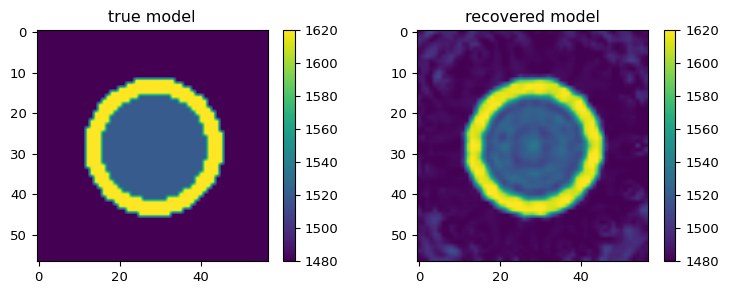

In [16]:
import matplotlib.pyplot as plt

# Compare the true vs the FWI recovered model
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(m, vmin=min_vel, vmax=max_vel, interpolation='bilinear')
plt.title('true model')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(model.get_model(), vmin=min_vel, vmax=max_vel, interpolation='bilinear')
plt.title('recovered model')
plt.colorbar()
plt.show()

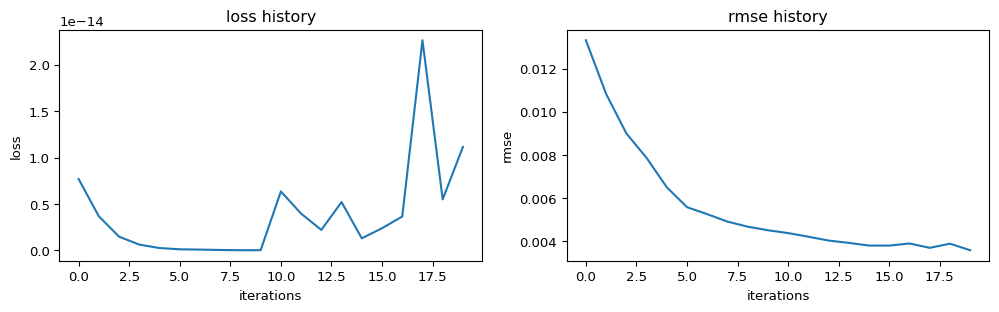

In [17]:
# View the inversion metrics
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(model.loss_history)
plt.title('loss history')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(model.rmse_history)
plt.title('rmse history')
plt.xlabel('iterations')
plt.ylabel('rmse')
plt.show()